In [19]:
# RFE
from sklearn.feature_selection import RFECV
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

X = np.load("./data/features_train_without_resp_norm.npy")
data = np.load("./data/train_without_resp.npy")
y = data[:,1004]

# 创建回归模型
regressor = LinearRegression()

# 创建 RFECV 实例
rfecv = RFECV(
    estimator=regressor,
    step=1,
    cv=5,  # 交叉验证的折数
    scoring="neg_mean_absolute_error",  # 使用均方误差来评估特征
)

# 运行 RFECV
rfecv.fit(X, y)

# 输出结果
print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", rfecv.support_)


Optimal number of features: 16
Selected features: [False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False]


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris
import numpy as np

feature = np.load("./data/features_train_without_resp_norm.npy")
print(feature.shape)
# feature = feature[:,[0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17]]
data = np.load("./data/train_without_resp.npy")
y = data[:,1004]

feature2 = np.load("./data/features_test_without_resp_norm.npy")
print(feature2.shape)
# feature2 = feature2[:,[0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17]]
data2 = np.load("./data/test_without_resp.npy")
y2 = data2[:,1004]

# 构建随机森林模型
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(feature, y)

pred = model.predict(feature2)
mae = np.sum(np.abs(pred - y2)) / len(pred)

print(mae)

# 获取特征重要性
feature_importances = model.feature_importances_

# 打印特征重要性
for i, importance in enumerate(feature_importances):
    print(f"Feature {i}: {importance:.4f}")

# 选择重要特征（例如，选择重要性大于等于0.1的特征）
selected_features = [i for i, importance in enumerate(feature_importances) if importance >= 0.1]
print("Selected Features:", selected_features)


(3879, 18)
(1909, 18)
20.99893137768465
Feature 0: 0.0011
Feature 1: 0.0010
Feature 2: 0.0018
Feature 3: 0.0012
Feature 4: 0.0022
Feature 5: 0.0008
Feature 6: 0.0005
Feature 7: 0.0009
Feature 8: 0.9775
Feature 9: 0.0018
Feature 10: 0.0017
Feature 11: 0.0019
Feature 12: 0.0027
Feature 13: 0.0008
Feature 14: 0.0010
Feature 15: 0.0008
Feature 16: 0.0011
Feature 17: 0.0011
Selected Features: [8]


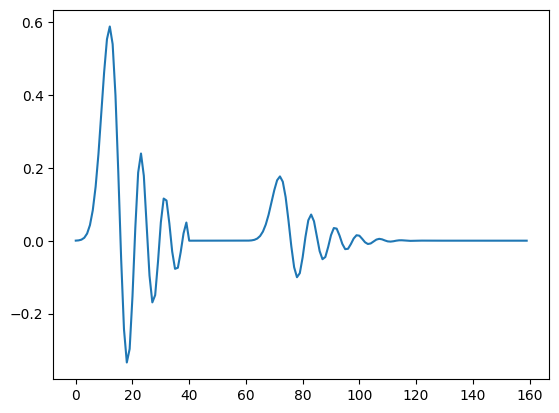

160
11


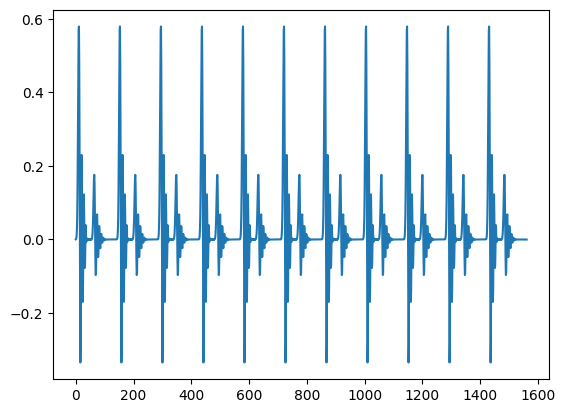

154.25414364640883


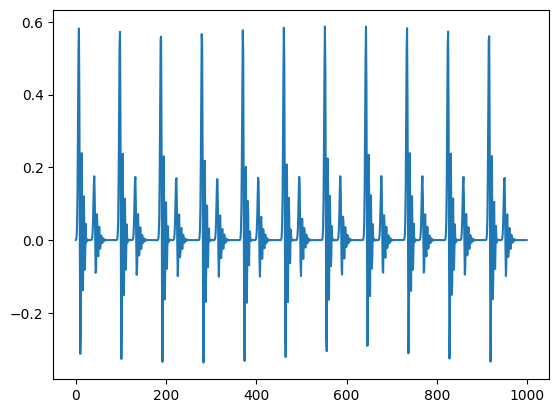

In [23]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema, find_peaks
from scipy.interpolate import interp1d


def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a

def fpeak(signal):
    signal2 = signal

    # 峰值检测
    peak_indices, _ = find_peaks(signal2)  # 返回极大值点的索引

    # 线性插值
    t_peaks = t[peak_indices]  # 极大值点的时间
    peak_values = signal2[peak_indices]  # 极大值点的幅值
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)

    peaks2,_ = find_peaks(envelope, distance = 10)

    peaks2 = update_array(peaks2, signal2)

    if(signal2[peaks2[0]]>signal2[peaks2[1]]):
        peaks2 = np.delete(peaks2, 0)

    if len(peaks2)%2 != 0:
        peaks2 = np.delete(peaks2, len(peaks2) - 1)
    
    return peaks2


def _resample_interpolation(signal, desired_length):
    resampled_signal = scipy.ndimage.zoom(signal, desired_length / len(signal))
    return resampled_signal

def signal_resample(
    signal, desired_length=None, sampling_rate=None, desired_sampling_rate=None, method="interpolation"
):
    
    if desired_length is None:
        desired_length = int(np.round(len(signal) * desired_sampling_rate / sampling_rate))

    # Sanity checks
    if len(signal) == desired_length:
        return signal

    # Resample
    if method.lower() == "fft":
        resampled = _resample_fft(signal, desired_length)
    elif method.lower() == "poly":
        resampled = _resample_poly(signal, desired_length)
    elif method.lower() == "numpy":
        resampled = _resample_numpy(signal, desired_length)
    elif method.lower() == "pandas":
        resampled = _resample_pandas(signal, desired_length)
    else:
        resampled = _resample_interpolation(signal, desired_length)

    return resampled

diastolic = 80
systolic=160


fs = 100
t = np.linspace(0, 10, 10 * fs)
sampling_rate = 100
heart_rate = 70
duration = 10
length = 1000

cardiac_length = int(100*sampling_rate/heart_rate) #sampling_rate #
# ind = random.randint(17, 34) 
ind = 24
cardiac_s = scipy.signal.daub(ind)
# plt.plot(cardiac_s)
cardiac_d = scipy.signal.daub(ind)*0.3*diastolic/80 # change height to 0.3
# plt.plot(cardiac_d)
# plt.show()

peak1, mag1 = scipy.signal.find_peaks(cardiac_s)
peak2, mag2 = scipy.signal.find_peaks(cardiac_d)

# print(cardiac_s[peak1])
# print(cardiac_d[peak2])
# print(cardiac_s[peak1]/cardiac_d[peak2])
# print(0.3*diastolic/80)
# print(len(cardiac_s))
cardiac_s = scipy.signal.resample(cardiac_s, 100)
cardiac_d = scipy.signal.resample(cardiac_d, 100)

# plt.plot(cardiac_s)
# plt.plot(cardiac_d)
# plt.show()

cardiac_s = cardiac_s[0:40]
distance = 180-systolic # systolic 81-180

zero_signal = np.zeros(distance)
cardiac = np.concatenate([cardiac_s, zero_signal, cardiac_d])
plt.plot(cardiac)
plt.show()
print(len(cardiac))
cardiac = scipy.signal.resample(cardiac, cardiac_length) # fix every cardiac length to 1000/heart_rate

# plt.plot(cardiac)
# plt.show()
# print(cardiac_length)

# # Caculate the number of beats in capture time period
num_heart_beats = int(duration * heart_rate / 60)
print(num_heart_beats)
# # Concatenate together the number of heart beats needed
scg = np.tile(cardiac, num_heart_beats)


plt.plot(scg)
plt.show()

# # Resample
scg = signal_resample(
    scg, sampling_rate=int(len(scg) / 10), desired_length=length, desired_sampling_rate=sampling_rate
)

peaks2 = fpeak(scg)
# print(peaks2)
D21 = peaks2[2]-peaks2[1]
# print(D21)
x = 600000/((D21*heart_rate)-6000) + 320
print(x)
plt.plot(scg)
plt.show()

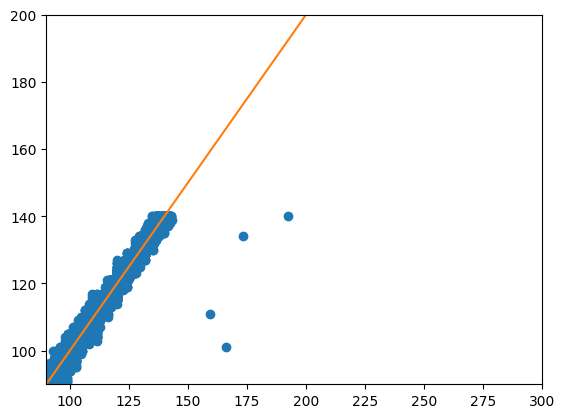

In [38]:
import matplotlib.pyplot as plt
import numpy as np
# 特征与S，D的关系
S_train = np.load("./data/train_without_resp.npy")[:,1004].flatten()
S_test = np.load("./data/test_without_resp.npy")[:,1004].flatten()
feature_train = np.load("./data/features_train_without_resp.npy")[:,8].flatten()
feature_test = np.load("./data/features_test_without_resp.npy")[:,5].flatten()
hr = np.load("./data/train_without_resp.npy")[:,1002].flatten() 
x = 220-(100*feature_train)
# x = 320-600000/(hr*feature_train)

# index = np.argmin(x)
# x = np.delete(x, index)
# S_train = np.delete(S_train, index)
# index = np.argmax(x)
# x = np.delete(x, index)
# S_train = np.delete(S_train, index)
# index = np.argmax(x)
# x = np.delete(x, index)
# S_train = np.delete(S_train, index)
plt.plot(x, S_train,"o")

x = np.linspace(90, 200, 80)
plt.plot(x,x)
plt.xlim(90, 300)
plt.ylim(90, 200)
plt.show()

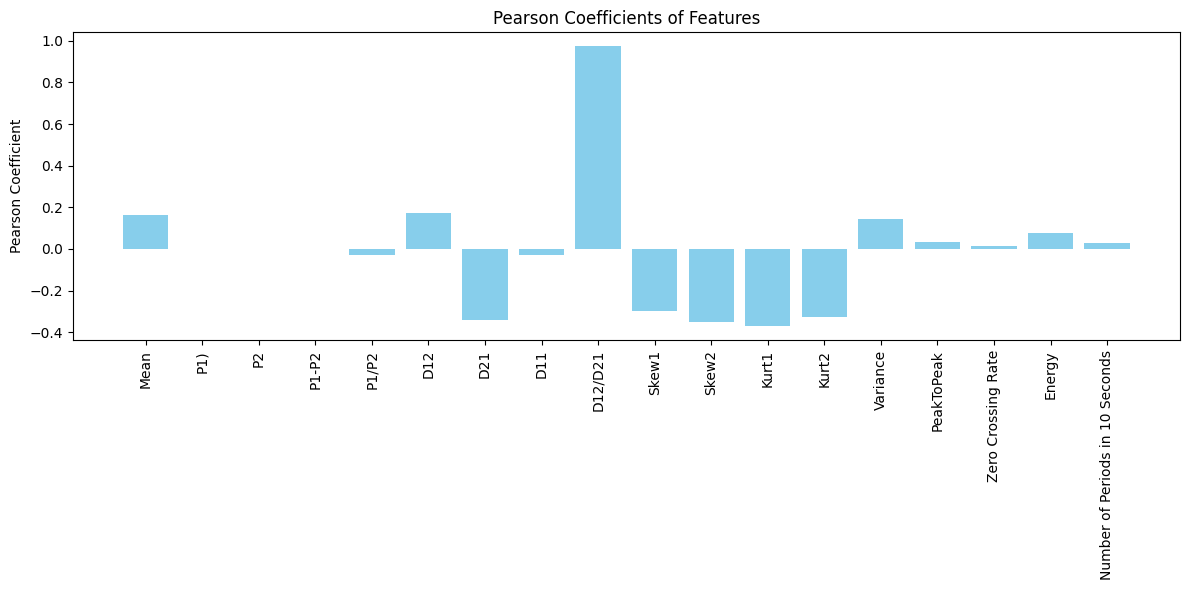

In [6]:
import matplotlib.pyplot as plt

# 特征名称
features = [
    "Mean",
    "P1",
    "P2",
    "P1-P2",
    "P1/P2",
    "D12",
    "D21",
    "D11",
    "D12/D21",
    "Skew1",
    "Skew2",
    "Kurt1",
    "Kurt2",
    "Variance",
    "PeakToPeak",
    "Zero Crossing Rate",
    "Energy",
    "Number of Periods in 10 Seconds"
]

# 皮尔逊系数值
pearson_coefficients = [
    0.1649,
    0.0008,
    0.0003,
    0.0007,
    -0.0309,
    0.1713,
    -0.3435,
    -0.0296,
    0.9735,
    -0.3001,
    -0.3533,
    -0.3719,
    -0.3297,
    0.1428,
    0.0334,
    0.0138,
    0.0760,
    0.0298
]

# 绘制柱状图
plt.figure(figsize=(12, 6))
plt.bar(range(len(features)), pearson_coefficients, color='skyblue')
plt.xticks(range(len(features)), features, rotation=90)
plt.ylabel('Pearson Coefficient')
plt.title('Pearson Coefficients of Features')
plt.tight_layout()
plt.show()


[-5.6878655e-07  0.0000000e+00  2.4400000e+02  6.3000000e+01
  1.1000000e+01  1.3800000e+02  8.9000000e+01]


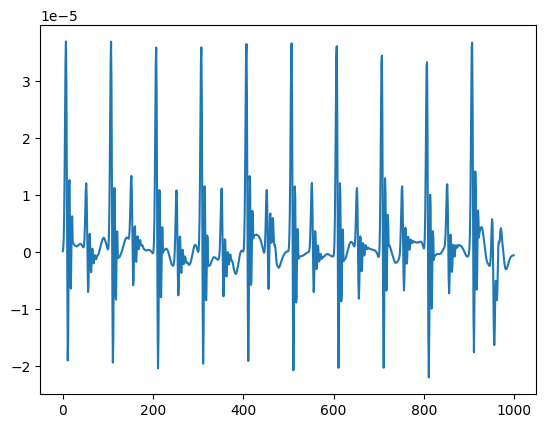

[1.25185775e-06 3.58804058e-05 1.09258430e-05 2.49545628e-05
 3.28399427e+00 5.50000000e+01 4.50000000e+01 1.00000000e+02
 1.22222222e+00 1.57013630e+00 1.30942734e+00 3.77750990e+00
 6.25527826e+00 4.54038607e-11 5.58364404e-05 1.80000000e+01
 5.68349203e-09 9.00000000e-01]


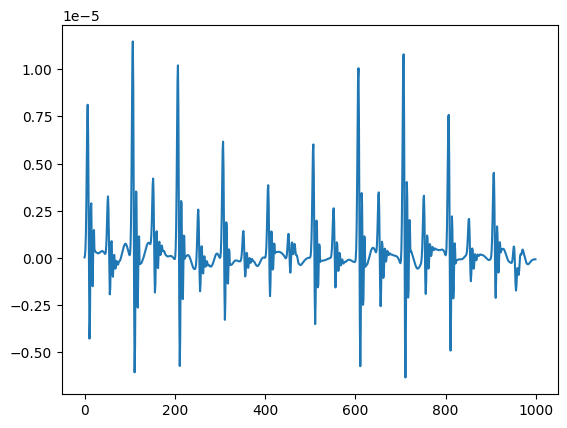

In [48]:
import numpy as np
import matplotlib.pyplot as plt

data_raw_train = np.load("data/simu_20000_0.1_90_140_train.npy")
data_raw_test = np.load("data/simu_10000_0.1_141_178_test.npy")
data_train_resp = np.load("data/train_without_resp.npy")
data_test_resp = np.load("data/test_without_resp.npy")
train_feature = np.load("data/features_train_without_resp.npy")
test_feature = np.load("data/features_test_without_resp.npy")

print(data_train_resp[45,999:])
plt.plot(data_train_resp[45,:1000])
plt.show()
print(train_feature[45,:])
plt.plot(data_raw_train[244,:1000])
plt.show()

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema, find_peaks
from scipy.interpolate import interp1d

def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a

def delete_unique(a):
    mean = np.mean(a)
    std = np.std(a)
    # 设置阈值
    threshold = 1
    # 使用布尔索引删除特殊值
    filtered_a = a[np.abs(a - mean) <= threshold * std]
    return filtered_a

data_test = np.load("./data/simu_10000_0.1_141_178_test.npy")
data_train = np.load("./data/simu_20000_0.1_90_140_train.npy")

fs = 100
t = np.linspace(0, 10, 10 * fs)

cnt = 0
index = []
tmpp = np.zeros(1006)
tmpind = np.zeros(70)

for j in range(233,234):
    signal2 = data_train[j, :1000]

    # 峰值检测
    peak_indices, _ = find_peaks(signal2)  # 返回极大值点的索引

    # 线性插值
    t_peaks = t[peak_indices]  # 极大值点的时间
    peak_values = signal2[peak_indices]  # 极大值点的幅值
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)

    peaks2,_ = find_peaks(envelope, distance = 10)

    peaks2 = update_array(peaks2, signal2)

    if(signal2[peaks2[0]]>signal2[peaks2[1]]):
        peaks2 = np.delete(peaks2, 0)

    if len(peaks2)%2 != 0:
        peaks2 = np.delete(peaks2, len(peaks2) - 1)


    # set the sample rate, the total time and the frequency
    #     sample_rate = 100  # sample rate in Hz
    #     total_time = 10  # total time in seconds


    # perform the fast fourier transform and compute the amplitude
    #     fft_vals = np.fft.rfft(signal2)
    #     fft_freq = np.fft.rfftfreq(len(t), 1.0/sample_rate)
    #     fft_amp = np.abs(fft_vals)

    # plot the frequency spectrum
    # plt.figure(figsize=(14, 5))
    # plt.plot(fft_freq, fft_amp)
    # plt.title('Frequency Spectrum')
    # plt.xlabel('Frequency (Hz)')
    # plt.ylabel('Amplitude')
    # plt.show()


    #     print(signal2[peaks2])

    #     plt.plot(t, signal2, label='原始信号')
    #     plt.show()

    from scipy.optimize import curve_fit
    import numpy as np
    import math




    def func(x, h1, h2, w):
        return (np.sin(w * x) * h1 + 2 * h1) * ((x % 2) * h2 + ((x+1) % 2) * h1)

    # 生成一些数据
    x = peaks2[:] / 100
    y = signal2[peaks2[:]] * 1e5

    # 使用curve_fit求解a
    try:
        popt, pcov = curve_fit(func, x, y)
    # 你的后续代码
    except RuntimeError:
        pass  # 不执行任何操作
        continue


    #     print('Estimated a:', popt[:])

    h1 = popt[0]
    h2 = popt[1]
    w = popt[2]


#     print(x)
#     print(y)

#     print(func(x, h1, h2, w))

    # print(signal[peaks2[::2]] / (1e-5 * w * np.sin(h1 * peaks2[::2] + 2e-5 * w)))


    t = np.linspace(0, 10, 10 * 100, endpoint=False)
    sin = (np.sin(w * t) * h1 + 2 * h1) * h1
    signal3 = signal2 / sin

    tmp = signal3[peaks2[1::2]] * 1e5
    

#     print(signal3[peaks2[::2]] * 1e5)
#     print(math.sqrt(0.1 * len(peaks2) / 2))
    
    
    
    if np.std(tmp) < math.sqrt(0.05 * len(peaks2) / 2):
        cnt += 1
        print(j, np.std(tmp), math.sqrt(0.05 * len(peaks2) / 2))
        index = np.append(index, j)
        signal4 = np.append(signal3, data_train[j,1000:])
        inddd = np.pad(peaks2, (0, 70-len(peaks2)), 'constant', constant_values=(0))
        tmpind = np.vstack([tmpind, inddd])
        tmpp = np.vstack([tmpp, signal4])
#         plt.plot(signal3)
#         plt.plot(peaks2, signal3[peaks2], 'o')
#         plt.show()

print(cnt)
print(index)

2 0.305088207488444 1.0723805294763609
25 0.4709043342323634 0.8944271909999159
27 0.4815640855066528 0.9746794344808964
38 0.2851528292487277 0.6708203932499369
39 0.8156207978510245 1.0723805294763609
50 0.5642005090525688 1.0
52 0.3961228951013584 1.02469507659596
65 0.3385342663893708 0.9219544457292888
73 0.5728238238933414 0.8660254037844386
76 0.31794468369816653 0.6324555320336759
81 0.45327045267950683 0.8944271909999159
83 0.3017661366693652 0.8660254037844386
91 0.40068005107483895 0.8944271909999159
98 0.3412737272312058 0.8660254037844386
100 0.29075290059309766 0.9486832980505138
109 0.29799722656410194 0.9486832980505138
112 0.5264764607902183 1.02469507659596
116 0.7096023964277834 1.0723805294763609
119 0.4719355410829948 1.02469507659596
122 0.41316499779454346 0.8944271909999159
127 0.2792510577627437 1.02469507659596
129 0.31569912966676855 0.9219544457292888
131 0.14806569079272777 0.7416198487095663
140 0.5279575354663347 0.7416198487095663
152 0.24326379881967772

1060 0.5921670962964095 1.0723805294763609
1066 0.532358815510953 1.0
1070 0.3165339063446604 1.0723805294763609
1071 0.4743949155786561 0.6708203932499369
1076 0.7681455328053151 1.0954451150103324
1079 0.36064770846775407 1.0
1082 0.2952315422875013 0.9219544457292888
1087 0.188813937008912 0.7416198487095663
1092 0.4198531271151677 0.6708203932499369
1093 0.49526621588881536 0.7416198487095663
1112 0.5579522565169827 0.8660254037844386
1123 0.21569351079113447 0.7745966692414834
1129 0.4536506647278429 1.0488088481701516
1134 0.6364184153022527 0.7071067811865476
1135 0.8024534432655706 1.02469507659596
1137 0.44925272157040047 0.7416198487095663
1143 0.4190925538545481 1.0723805294763609
1152 0.374125800925417 0.7416198487095663
1153 0.20984212382531178 0.8366600265340756
1156 0.19408794298461748 0.6708203932499369
1163 0.616353967890444 0.7071067811865476
1172 0.5084875975579722 0.5916079783099616
1178 0.5864039533394693 1.02469507659596
1182 0.24077225266577137 0.7745966692414834

2193 0.3475259616041868 0.8660254037844386
2201 0.43326455291447646 0.9746794344808964
2202 0.25788049296873167 0.9486832980505138
2205 0.6333190658134654 1.02469507659596
2214 0.16928857769081215 0.6708203932499369
2216 0.18724112238538754 0.8366600265340756
2229 0.3200980227303258 0.9219544457292888
2231 0.19408170253672463 0.6708203932499369
2232 0.264171203571544 0.9486832980505138
2240 0.25259792063691683 0.6324555320336759
2247 0.22234813615713056 0.806225774829855
2249 0.13606965733562518 0.8366600265340756
2250 0.12472773571966805 0.8366600265340756
2252 0.6576770975316375 1.02469507659596
2270 0.4233428499775138 1.02469507659596
2285 0.8049109907175043 1.0723805294763609
2293 0.7923722819637788 1.0488088481701516
2299 0.2883829083617921 0.8660254037844386
2305 0.5038746991723398 0.9486832980505138
2309 0.1234060250312411 0.6324555320336759
2316 0.3981193079623744 1.02469507659596
2321 0.42114052792420237 0.9486832980505138
2322 0.2809939574371304 0.9486832980505138
2326 0.4333

3427 0.43716972896217343 0.9486832980505138
3429 0.4041637216866391 1.0723805294763609
3430 0.1922818731898112 0.7745966692414834
3433 0.43258488838330206 0.7416198487095663
3439 0.24575130657827834 0.6324555320336759
3450 0.18372153098430194 0.8366600265340756
3468 0.37823167136565217 0.9486832980505138
3469 0.5735278690069289 1.0723805294763609
3479 0.470296453029882 0.8944271909999159
3480 0.2946594777176505 0.8660254037844386
3482 0.16658649303929923 0.6708203932499369
3499 0.5672915564719399 0.8944271909999159
3505 0.4814165543913354 0.8660254037844386
3515 0.28704201196661494 1.02469507659596
3516 0.7818474703918289 1.0723805294763609
3532 0.20805009199811864 0.9746794344808964
3533 0.570936569968579 0.9746794344808964
3537 0.10231191287891739 0.6708203932499369
3542 0.33513901076457825 0.7416198487095663
3544 0.5625264001947672 1.02469507659596
3545 0.23551952062001089 0.6708203932499369
3546 0.1914412791159096 0.9486832980505138
3547 0.8398997256449209 1.02469507659596
3549 0.1

4382 0.6811741678103647 0.9219544457292888
4386 0.5675518863343503 0.8944271909999159
4388 0.12285498526216615 0.9746794344808964
4394 0.18402273756797755 0.8366600265340756
4396 0.25706210712745275 0.7745966692414834
4398 0.41057141093822114 0.806225774829855
4400 0.2671070595012339 0.806225774829855
4401 0.5804996092984115 0.7416198487095663
4402 0.38249016527537427 0.9746794344808964
4404 0.3265832117054819 0.806225774829855
4408 0.20589403417386457 0.9746794344808964
4414 0.3586133705633711 0.8944271909999159
4416 0.19419483864640122 0.7745966692414834
4420 0.44116118606454235 0.7071067811865476
4422 0.30319051732549906 0.7416198487095663
4430 0.25158547336131737 0.8366600265340756
4435 0.15209044954319684 0.7745966692414834
4436 0.8852285762364273 1.0
4437 0.4145266089037194 1.0488088481701516
4438 0.30753934501150165 1.0723805294763609
4439 0.1817020642230753 0.8366600265340756
4440 0.4121779791303735 0.9219544457292888
4443 0.2566501015448452 0.9746794344808964
4445 0.4507703808

5412 0.2985631898541945 1.0
5415 0.28635637189016094 0.9486832980505138
5418 0.5360461773080456 0.9486832980505138
5422 0.2882603238038884 0.9219544457292888
5426 0.5473816083781273 1.0723805294763609
5435 0.3554063235499156 0.8660254037844386
5446 0.3663732268346254 1.02469507659596
5447 0.35135703962153525 0.9219544457292888
5452 0.27316613373052245 0.9486832980505138
5455 0.13628987169660556 0.5916079783099616
5470 0.44243265910577306 0.8660254037844386
5479 0.33389475320576223 0.9746794344808964
5486 0.311328411506553 0.806225774829855
5490 0.3749494307776853 0.9486832980505138
5496 0.258689760275775 0.7071067811865476
5500 0.42278288178467816 0.8660254037844386
5501 0.22104283241331465 0.6708203932499369
5509 0.19634874055535415 0.8366600265340756
5513 0.5232468711397221 0.9219544457292888
5514 0.07771642309807775 1.0954451150103324
5517 0.19043363640255268 0.8366600265340756
5529 0.21107327288993322 0.8366600265340756
5539 0.516930633638537 0.7416198487095663
5541 0.5406509624202

6436 0.19961444285950877 0.806225774829855
6438 0.39399447809503046 0.6324555320336759
6439 0.5422330786132968 0.8660254037844386
6444 0.40189550288763626 1.02469507659596
6446 0.36554161226104703 1.0723805294763609
6449 0.6447490957026022 0.8944271909999159
6452 0.4435211338093853 0.8944271909999159
6463 0.2416014597830214 0.6324555320336759
6468 0.16192746827693064 0.6708203932499369
6470 0.34337999881210307 0.9486832980505138
6484 0.5559337168191137 1.0
6487 0.23581561998881417 0.7745966692414834
6493 0.3066846834258374 0.8660254037844386
6500 0.5142487167955747 0.9486832980505138
6532 0.560856986336296 0.8660254037844386
6534 0.21083843134639219 0.6324555320336759
6536 0.37368479294297 0.8944271909999159
6541 0.25279791669611523 0.9486832980505138
6545 0.4909848129699146 0.8944271909999159
6546 0.34814939294101427 0.806225774829855
6556 0.300320568407735 0.806225774829855
6563 0.693720641451311 0.8944271909999159
6567 0.2113245264388784 0.7416198487095663
6571 0.20647479154840007 0

7599 0.45493335457226763 0.8660254037844386
7600 0.38061596822327487 0.9486832980505138
7605 0.4251018232461255 0.8660254037844386
7608 0.3462904992763344 0.6708203932499369
7610 0.2104021284743644 0.806225774829855
7612 0.6514723679026303 0.6708203932499369
7627 0.49034177799027384 0.8660254037844386
7628 0.315712661485481 1.02469507659596
7629 0.30485672441894507 0.8660254037844386
7633 0.176752109227968 0.8660254037844386
7635 0.20680977220578212 0.9746794344808964
7645 0.3144822150214599 1.0488088481701516
7656 0.3697691353323882 1.0
7662 0.4426016842459725 0.8660254037844386
7671 0.391694079356953 0.9746794344808964
7672 0.19585487891144124 0.7745966692414834
7675 0.19875950347500648 0.6324555320336759
7690 0.32241194785263705 0.9486832980505138
7695 0.1883180504453321 0.8366600265340756
7699 0.5675452462140278 1.0723805294763609
7703 0.2662208851015195 0.7745966692414834
7711 0.27564757907575105 0.806225774829855
7712 0.3078715679596315 0.9486832980505138
7715 0.4648162219550134 

8682 0.2383560536481642 0.806225774829855
8684 0.4041427870829262 0.8660254037844386
8689 0.23498282825029057 0.806225774829855
8693 0.14770835178595929 0.7745966692414834
8704 0.30220284287347654 0.8660254037844386
8728 0.42929241318555755 1.0488088481701516
8731 0.5375604826947393 1.02469507659596
8736 0.3246920804162562 1.0488088481701516
8737 0.3224305810484593 0.9746794344808964
8742 0.20503203701938078 0.806225774829855
8745 0.5101364182608322 1.0
8746 0.5428635417660681 0.6708203932499369
8748 0.4508414432746035 1.0
8758 0.10385517100186742 1.0954451150103324
8761 0.7272546693664956 1.0723805294763609
8764 0.6684119265148329 0.8660254037844386
8765 0.5238427249812704 0.806225774829855
8766 0.3682810981853667 0.9219544457292888
8770 0.486983429704911 1.0723805294763609
8778 0.47258278274235377 0.9219544457292888
8786 0.3458179355751014 0.806225774829855
8797 0.6463242312788302 1.0488088481701516
8803 0.4289493589285152 1.02469507659596
8804 0.3074898145674695 1.0488088481701516
8

9730 0.4171799159531078 0.5916079783099616
9736 0.18301347821212235 0.7745966692414834
9739 0.40362597719540444 0.9746794344808964
9743 0.35119483352476133 0.9746794344808964
9746 0.19164518339552716 0.7745966692414834
9750 0.2321254789804248 0.6324555320336759
9758 0.7048694632795017 0.7071067811865476
9767 0.3596005505204523 0.9486832980505138
9771 0.15996965777956731 0.9746794344808964
9772 0.35844801886414407 0.9746794344808964
9775 0.5020813434284244 0.806225774829855
9777 0.6353379731742628 1.02469507659596
9789 0.19595373873686478 0.6708203932499369
9799 0.7493013863477448 1.0723805294763609
9800 0.7608354918265304 1.0723805294763609
9803 0.5383228236118417 1.02469507659596
9805 0.15713882972791576 0.8366600265340756
9807 0.2538829720767232 0.8944271909999159
9811 0.2929995611263708 0.7745966692414834
9819 0.3486485875518286 1.02469507659596
9820 0.5272323706435489 0.8944271909999159
9835 0.7429358428117127 1.0723805294763609
9843 0.47374725299180864 1.0723805294763609
9849 0.55

10717 0.3811410363569935 0.6708203932499369
10723 0.5307130898343244 0.9219544457292888
10727 0.24887815096698196 0.9746794344808964
10728 0.16785821954544158 0.7416198487095663
10737 0.24307727935484397 0.5916079783099616
10742 0.5243015108181001 1.0
10745 0.3645707716427018 0.9219544457292888
10746 0.39089833625015674 0.8660254037844386
10751 0.18619058242243516 0.9746794344808964
10753 0.4779547925165106 0.9486832980505138
10774 0.4638403786457286 1.0
10778 0.39022892816481497 0.8660254037844386
10786 0.7434806047701745 0.9219544457292888
10791 0.5843628280888687 0.8660254037844386
10792 0.49120540941471774 1.0
10795 0.21846594901803965 0.6324555320336759
10803 0.3024194530614135 0.7071067811865476
10804 0.3889110829356843 0.6708203932499369
10807 0.49026054737404806 0.7416198487095663
10811 0.45482450003560454 0.9486832980505138
10815 0.4958300867133897 1.0723805294763609
10822 0.10964496333507627 0.9746794344808964
10827 0.332529813823227 0.8660254037844386
10832 0.167018620620733

11774 0.30204539050454865 0.8660254037844386
11777 0.24836343500768313 0.7416198487095663
11779 0.5555849202627345 0.7071067811865476
11786 0.3642911526090488 0.9486832980505138
11790 0.2107694107449203 0.6324555320336759
11793 0.2153489833726156 0.6708203932499369
11794 0.45470146842361525 1.0
11796 0.37353238674735073 0.6708203932499369
11799 0.1430392145065106 0.6324555320336759
11801 0.5000000152106233 0.9746794344808964
11804 0.4033224607899754 1.0488088481701516
11807 0.2369527729214538 0.806225774829855
11808 0.5201237682302531 1.02469507659596
11815 0.49194688470801706 0.8660254037844386
11818 0.4041922680513971 0.9219544457292888
11850 0.35469954365427575 0.6324555320336759
11853 0.27019752546988257 0.7745966692414834
11854 0.1547345519995638 0.8366600265340756
11857 0.6111877423960784 0.7416198487095663
11870 0.3155594249324035 1.0
11877 0.2637174205823257 0.6324555320336759
11884 0.4420501873975019 0.8944271909999159
11888 0.44398407661509126 1.02469507659596
11894 0.3123640

12760 0.16350356385850265 0.6324555320336759
12762 0.35320492914906143 1.0488088481701516
12771 0.20823178959344998 0.7745966692414834
12782 0.4414481749115855 1.0
12784 0.22429391889037845 0.7745966692414834
12789 0.6885313834891366 0.7071067811865476
12795 0.20950989145580093 0.7745966692414834
12797 0.20470091186300088 0.7745966692414834
12800 0.31502693813222177 0.7745966692414834
12802 0.15152652087882015 0.7745966692414834
12804 0.6322680287330129 0.7071067811865476
12810 0.2800661648583287 0.6324555320336759
12815 0.18522233810222705 0.7745966692414834
12830 0.5874517472981101 0.8660254037844386
12831 0.1462703605882334 0.6324555320336759
12845 0.20920990489700966 0.7745966692414834
12846 0.2534910823311981 0.7416198487095663
12851 0.422164550668483 1.02469507659596
12852 0.22997429708519287 0.9746794344808964
12853 0.18808287734578574 1.0954451150103324
12862 0.5018188947779751 0.9486832980505138
12863 0.8337521936677081 1.0723805294763609
12874 0.27883109104861653 0.6708203932

13847 0.6539414014256201 1.0488088481701516
13849 0.22632548547798265 0.7071067811865476
13854 0.4550883090055405 1.0488088481701516
13860 0.46694139811704105 1.02469507659596
13886 0.3471614458030779 0.8944271909999159
13888 0.39087756683888764 0.7416198487095663
13914 0.3505151706441063 0.9746794344808964
13923 0.31526093658731946 0.9486832980505138
13936 0.5645651398275673 0.9219544457292888
13963 0.26574227388796656 0.6708203932499369
13964 0.3552514764922466 0.9219544457292888
13970 0.4218386577352309 1.02469507659596
13971 0.4141150173929028 0.8944271909999159
13976 0.4337023652141387 0.7416198487095663
13977 0.3980339559258505 0.8944271909999159
13983 0.3415995534163575 0.6324555320336759
14000 0.9256171224037888 1.0
14001 0.5179573087377763 1.0
14012 0.12808940232323493 0.806225774829855
14018 0.5551025824265461 1.02469507659596
14035 0.6969844944533736 1.0488088481701516
14036 0.5899068367167486 1.02469507659596
14044 0.4056964455785971 0.7071067811865476
14046 0.3666179067737

14886 0.3714176533278821 0.6708203932499369
14887 0.24263233582873275 0.7745966692414834
14888 0.33484180051524604 0.9486832980505138
14890 0.3187767100449118 0.9486832980505138
14891 0.3518077693438396 0.806225774829855
14892 0.2860823258852184 0.6324555320336759
14899 0.16454684149167972 0.8660254037844386
14904 0.23950033031576207 0.7416198487095663
14905 0.36168291100620364 1.0723805294763609
14910 0.794868355237876 0.8366600265340756
14912 0.5602109901018171 0.9746794344808964
14921 0.6229251280357667 0.7071067811865476
14923 0.25217887091206836 0.7745966692414834
14931 0.3623618026547911 0.6708203932499369
14936 0.24717156946325042 0.806225774829855
14938 0.25491720636242865 1.0488088481701516
14940 0.277746177489081 0.9486832980505138
14949 0.526914342095396 1.0954451150103324
14954 0.4105208505571392 0.806225774829855
14959 0.35269763433566903 0.6708203932499369
14960 0.5686547871484811 0.8944271909999159
14963 0.4006479135040473 0.9219544457292888
14971 0.2658413084745931 1.0


15817 0.43554227793909867 0.9486832980505138
15818 0.48956490581643103 1.0
15827 0.33863610361431273 1.0723805294763609
15828 0.12338458636581104 0.6324555320336759
15834 0.19874950423891097 0.8366600265340756
15836 0.6143878274223864 1.0723805294763609
15840 0.20539376535715817 0.8366600265340756
15849 0.1061307910195543 0.8366600265340756
15852 0.22948177225700697 0.9746794344808964
15853 0.17101655137081775 0.7416198487095663
15854 0.4489518737002652 0.7416198487095663
15858 0.2963840307346613 0.7416198487095663
15860 0.24297553755919465 0.6324555320336759
15865 0.5062390659573927 0.9486832980505138
15882 0.1787471141538427 0.8366600265340756
15889 0.7030419424219223 0.7071067811865476
15893 0.4455914917643072 0.8944271909999159
15900 0.464412818355521 0.6324555320336759
15907 0.5601798698202423 1.0
15908 0.531919187719775 0.9746794344808964
15909 0.22955938342688775 0.9746794344808964
15912 0.39554999654047973 1.0723805294763609
15913 0.6119972194797195 0.8660254037844386
15932 0.1

16741 0.2166068527619923 0.8366600265340756
16745 0.6977869829451975 0.7071067811865476
16748 0.3473247308700414 0.806225774829855
16756 0.523395282175458 0.9219544457292888
16757 0.39439244024519743 0.9219544457292888
16776 0.35529283676610784 0.8660254037844386
16782 0.1356803421129 0.9746794344808964
16784 0.3867725190590318 1.02469507659596
16785 0.5911744856760882 1.0488088481701516
16787 0.3427267479729271 1.02469507659596
16788 0.2972662632256977 0.806225774829855
16793 0.2377741482007133 0.7416198487095663
16797 0.3676278273543835 1.0
16798 0.22589934329811492 0.7745966692414834
16799 0.34164532460187136 0.7416198487095663
16800 0.25513903548507744 0.9746794344808964
16802 0.4656854367106405 0.9219544457292888
16812 0.5214168703352368 0.9486832980505138
16820 0.15713825711027551 0.6708203932499369
16823 0.6753590004837964 1.0723805294763609
16832 0.19431174222121847 0.7745966692414834
16849 0.6033634123635653 0.9219544457292888
16852 0.601943878807752 1.0
16858 0.32233876644059

17635 0.3163318537426826 0.9219544457292888
17638 0.11420570804927178 0.6324555320336759
17653 0.6622829926708452 1.0723805294763609
17656 0.3946024720242751 0.8944271909999159
17661 0.29270194940508565 0.806225774829855
17673 0.41865403117681094 0.7745966692414834
17674 0.3008025064602784 0.9486832980505138
17683 0.6119023512849013 0.7071067811865476
17687 0.2930986384124886 1.0488088481701516
17690 0.531808524183751 1.0723805294763609
17695 0.15035581643003626 0.5916079783099616
17702 0.4122931534696801 0.5916079783099616
17704 0.44792424834763317 1.0723805294763609
17706 0.6370172525394943 0.8944271909999159
17707 0.3175866072220384 0.7745966692414834
17728 0.18823004308331237 0.9746794344808964
17750 0.34769478111265006 0.9486832980505138
17753 0.39255503715158696 0.5916079783099616
17754 0.30180779964402704 0.9746794344808964
17757 0.8481652951216108 1.0
17774 0.4664874940894148 0.9486832980505138
17776 0.46910912927934606 0.8944271909999159
17781 0.3482224601534648 1.024695076595

18628 0.4847746312461601 0.7745966692414834
18630 0.8981604670043352 1.0
18634 0.0721358612844339 0.7745966692414834
18636 0.861077202699386 1.0488088481701516
18637 0.566421099246025 1.0723805294763609
18645 0.4643633091136553 0.806225774829855
18648 0.31367670995723085 0.7416198487095663
18658 0.4527683630725967 0.6708203932499369
18662 0.47022750669641306 0.7071067811865476
18665 0.3793081567209976 0.9486832980505138
18668 0.27316659483185934 0.8366600265340756
18670 0.2263716896727283 0.806225774829855
18675 0.3384766056573216 0.9746794344808964
18676 0.2003523703889775 0.8366600265340756
18686 0.21866218060519857 0.8366600265340756
18699 0.3830517951044452 1.02469507659596
18717 0.36471389509716096 0.8660254037844386
18725 0.2507674415485003 0.806225774829855
18735 0.4439828491410592 0.806225774829855
18739 0.3683165965283934 0.6708203932499369
18743 1.0066975060191257 1.02469507659596
18746 0.35625304169816796 1.0723805294763609
18765 0.5311947527757196 1.0723805294763609
18767 0

19663 0.43921705360606383 0.7416198487095663
19671 0.310418104112771 0.9486832980505138
19672 0.23185546802498028 0.8366600265340756
19674 0.27955008275262316 1.0723805294763609
19684 0.24093694348410052 0.6324555320336759
19686 0.7172339446804016 1.0
19688 0.4097813670559508 0.8660254037844386
19692 0.2988536272551425 1.0
19695 0.7349644182003033 0.9746794344808964
19711 0.3048333663484762 0.6708203932499369
19714 0.1707808463388151 0.9746794344808964
19720 0.2620144239190436 1.02469507659596
19721 0.20379058331317162 0.8366600265340756
19723 0.14001274426086707 0.8366600265340756
19734 0.38791856748711073 0.806225774829855
19736 0.7455401217978138 1.02469507659596
19738 0.4391682317224343 0.8944271909999159
19743 0.6427837179562953 1.0
19744 0.46626416987400077 0.7416198487095663
19754 0.4556249235958214 0.9486832980505138
19757 0.6902589028687737 1.02469507659596
19758 0.4033951764891947 0.9486832980505138
19766 0.13930300455846387 0.7745966692414834
19771 0.3803188831732793 0.80622

(3880, 1006)
[0. 0. 0. ... 0. 0. 0.]
(3880, 70)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


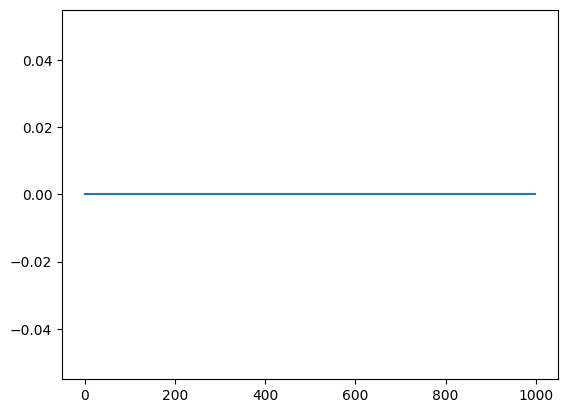

In [112]:
print(tmpp.shape)
print(tmpp[0,:])
print(tmpind.shape)
print(tmpind[0,:])

plt.plot(tmpp[0, :1000])
plt.show()

tmpp = tmpp[1:,:]
tmpind = tmpind[1:,:]

np.save('./data/train_without_resp.npy', tmpp)
np.save('./data/train_without_resp_peaks.npy', tmpind)

In [10]:
index = index.astype(int)
# print(index)
# 加载y
y = np.load('./data/simu_20000_0.1_90_140_train.npy')

# 以x为行号，提取y中的对应行
selected_rows = y[index, :]

# plt.plot(y[0,:1000])
# plt.show()
# 保存到新的.npy文件
np.save('./data/train_without_resp.npy', selected_rows)



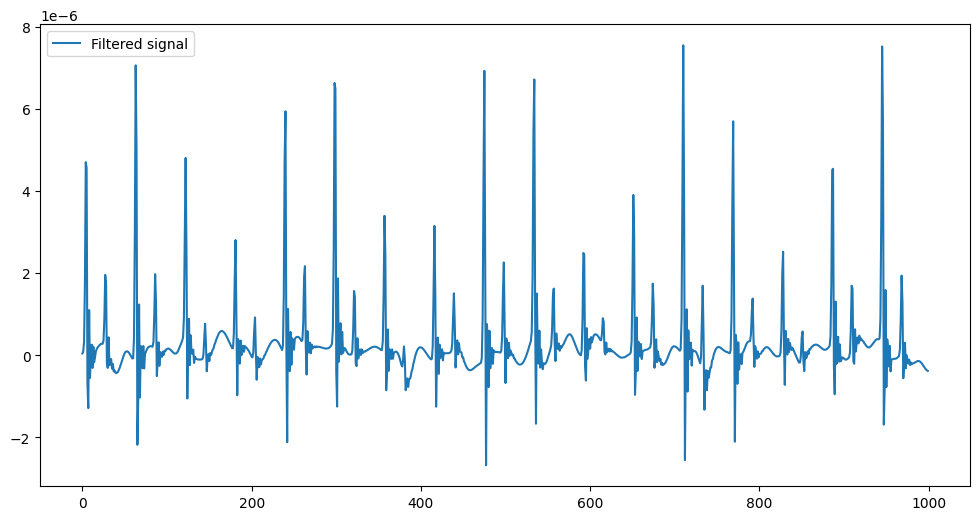

In [176]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

# Your signal and sampling rate
your_signal = signal2.reshape(1000)
# your_signal = np.sin(2 * np.pi * 10 * np.linspace(0, 10, 1000))
fs = 100  # Sampling rate

# Frequencies to be removed from signal (notch filter)
freqs_to_remove = 16  # Frequencies of the noise
Q = 2  # Quality factor

# For each frequency to be removed, apply notch filter
# for f0 in freqs_to_remove:
# Design notch filter
b, a = signal.iirnotch(f0, Q, fs)

# Apply filter to signal
your_signal = signal.lfilter(b, a, your_signal)

# Plot original and filtered signal
plt.figure(figsize=(12, 6))
plt.plot(your_signal, label='Filtered signal')
# plt.plot(signal2)
plt.legend(loc='best')
plt.show()


In [223]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# 数据
x = torch.tensor(peaks2[:] / 100)
y = torch.tensor(signal2[peaks2[:]] * 1e5)

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.w = nn.Parameter(torch.rand(1))
        self.h1 = nn.Parameter(torch.rand(1))
        self.h2 = nn.Parameter(torch.rand(1))

    def forward(self, x):
        return torch.where(x % 2 == 0, (torch.sin(self.w * x) * self.h1 + 2 * self.h1) * self.h1,
                           (torch.sin(self.w * x) * self.h1 + 2 * self.h1) * self.h2)

# 创建模型
model = CustomModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
for i in range(1000):
    optimizer.zero_grad()
    output = model(x)
    loss = nn.MSELoss()(output, y)
    loss.backward()
    optimizer.step()

print('w: ', model.w.item())
print('h1: ', model.h1.item())
print('h2: ', model.h2.item())

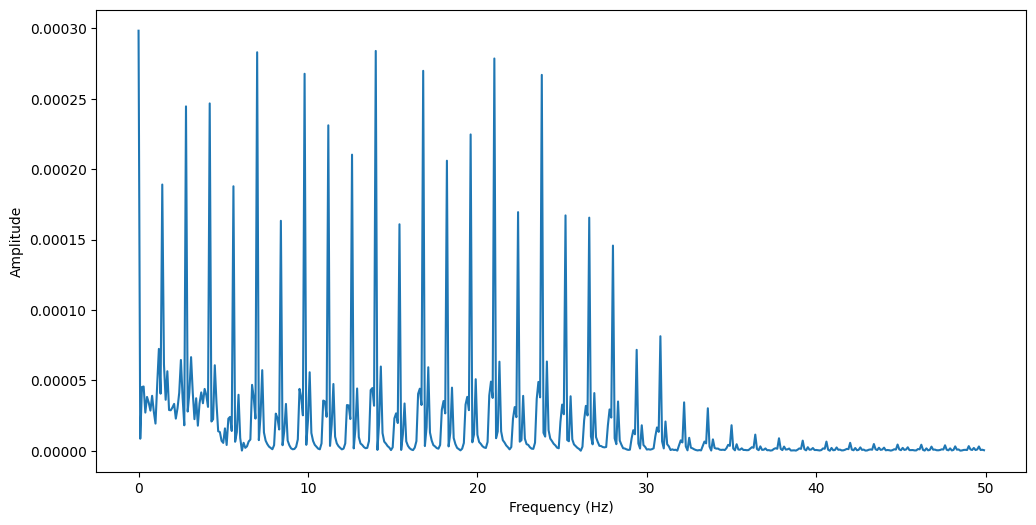

In [13]:
fft_val = np.fft.fft(signal)

# 计算对应的频率值
sample_rate = 100  # 采样频率
n = len(signal)  # 信号的长度
freq = np.fft.fftfreq(n, 1/sample_rate)

# 取绝对值：将复数变为实数，只保留幅度
fft_val = np.abs(fft_val)

# 由于对称性，我们只需要取前一半（正频率部分）
fft_val = fft_val[:n//2]
freq = freq[:n//2]

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(freq, fft_val)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()


In [13]:
import numpy as np
from gplearn.genetic import SymbolicRegressor
from sklearn.utils.random import check_random_state

# 定义训练数据
x = peaks2.reshape(-1,1)
y = signal[peaks2].reshape(-1,1)

# 定义并训练模型
est_gp = SymbolicRegressor(population_size=5000, generations=20, 
                           stopping_criteria=0.01, p_crossover=0.7, 
                           p_subtree_mutation=0.1, p_hoist_mutation=0.05, 
                           p_point_mutation=0.1, max_samples=0.9, 
                           verbose=1, parsimony_coefficient=0.01, 
                           random_state=0, function_set=('add', 'sub', 'mul', 'div', 'sin', 'cos', 'log'))
est_gp.fit(x, y)

# 输出结果
print('The equation found by SymbolicRegressor is:')
print(est_gp._program)


C:\Users\darcy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    18.73      1.10088e+09       39      4.04438e-06      8.54094e-06     57.04s
The equation found by SymbolicRegressor is:
div(div(mul(sub(div(0.591, X0), cos(0.824)), log(div(X0, X0))), div(mul(cos(X0), sin(0.415)), sin(log(X0)))), sub(add(div(cos(X0), sin(0.148)), log(sin(X0))), div(cos(sin(X0)), log(sin(X0)))))


hr: 86 rr: 12 sp: 167 dp: 97


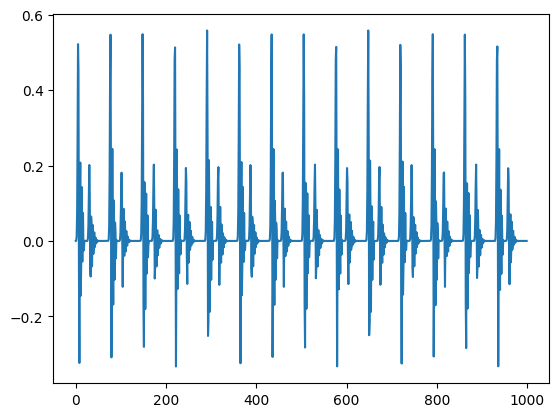

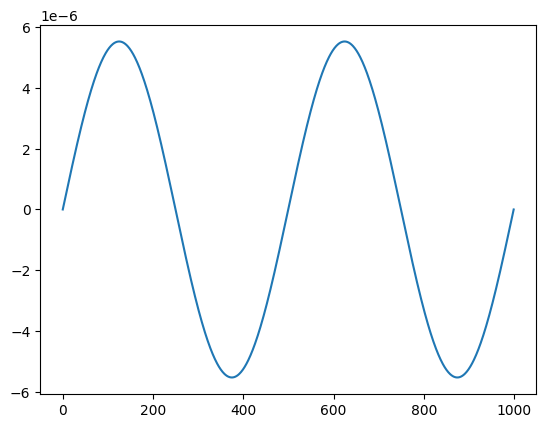

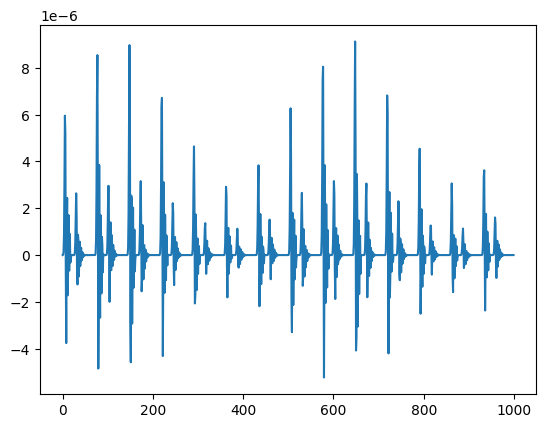

In [1]:
import warnings
warnings.filterwarnings('ignore')
# Load NeuroKit and other useful packages
import sys
sys.path.insert(1, './')
import DataDemo.datasim as nk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import signal
from tqdm import tqdm
import math
import random
import numpy as np
import scipy
from DataDemo.datasim.signal import signal_distort, signal_resample
import matplotlib.pyplot as plt

fs = 100
duration = 10
heart_rate = random.randint(50, 150)
respiratory_rate = random.randint(10, 30)
systolic = random.randint(140, 180)
diastolic = random.randint(60,100) #+ systolic

duration=duration
sampling_rate=fs
noise=0
heart_rate=heart_rate
respiratory_rate=respiratory_rate
systolic=systolic
diastolic=diastolic
length=duration * sampling_rate

print('hr:', heart_rate, 'rr:', respiratory_rate, 'sp:', systolic, 'dp:', diastolic)
# data = nk.scg_simulate(duration=duration, sampling_rate=fs, noise=noise, heart_rate=heart_rate, respiratory_rate=respiratory_rate, systolic=systolic, diastolic=diastolic)

cardiac_length = int(100*sampling_rate/heart_rate) #sampling_rate #
ind = random.randint(17, 34) 
# ind = 20
cardiac_s = scipy.signal.wavelets.daub(ind)
cardiac_d = scipy.signal.wavelets.daub(ind)*0.3*diastolic/80 # change height to 0.3
cardiac_s = scipy.signal.resample(cardiac_s, 100)
cardiac_d = scipy.signal.resample(cardiac_d, 100)
cardiac_s = cardiac_s[0:40]
distance = 180-systolic # systolic 81-180
# distance = cardiac_length - len(cardiac_s) - len(cardiac_d) - systolic # here 140 = 40 (cardiac_s) + 100 (cardiac_d) as below
zero_signal = np.zeros(distance)
cardiac = np.concatenate([cardiac_s, zero_signal, cardiac_d])
# cardiac = scipy.signal.resample(cardiac, 100) # fix every cardiac length to 100
cardiac = scipy.signal.resample(cardiac, cardiac_length) # fix every cardiac length to 1000/heart_rate

# Caculate the number of beats in capture time period
num_heart_beats = int(duration * heart_rate / 60)

# Concatenate together the number of heart beats needed
scg = np.tile(cardiac, num_heart_beats)



num_points = duration * sampling_rate
x_space = np.linspace(0,1,num_points)
seg_fre = respiratory_rate / (60/duration)
seg_amp = max(scg) * 0.00001
rr_component = seg_amp * np.sin(2 * np.pi * seg_fre * x_space)

# Resample
scg = signal_resample(
    scg, sampling_rate=int(len(scg) / 10), desired_length=length, desired_sampling_rate=sampling_rate
)

scg2 =scg * (rr_component + 2 * seg_amp)

plt.plot(scg)
plt.show()
plt.plot(rr_component)
plt.show()
plt.plot(scg2)
plt.show()